In [1]:
# Основная идея - генерируем полный отчет за все даты указанные для каждого вагона (декартовое произведение)
# Далее собираем информацию по вагонам и генерируем признаки - агрегаты за месяцы наблюдений. Далее производим сдвиг,
# чтобы имея данные за наблюдаемый месяц предсказывать следующий.

# В качестве алгоритма моделирования используется градиентный бустинг - Catboost,
# Учим 2 модели на каждую задачу, метрика PR_AUC, далее настраиваем порог
# для максимизации f1_score.


# %% [markdown]
# Импорт библиотек, констант, данных

import warnings

In [2]:
from functools import reduce

import catboost
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from src.config import ModelingConfig
from src.utils import optimize_df_memory

/Users/lev_grafon/DS_START_ML/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Константы
conf = ModelingConfig()

USE_OPTUNA = False
PATH_TRAIN_FISRT = r"../data/raw/train_1"
PATH_TRAIN_SECOND = r"../data/raw/train_2"

In [4]:
# Настройка библиотек
warnings.filterwarnings("ignore")

In [5]:
pd.set_option("display.max_columns", conf.pd_max_cols)
pd.set_option("display.max_rows", conf.pd_max_rows)

In [6]:
sns.set_style("darkgrid")
sns.set({"figure.figsize": conf.sns_fig_size})

# %% [markdown]
# ## Загрузка данных

# Cписок вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.concat(
    map(
        lambda x: pd.read_parquet(x + "/wagons_probeg_ownersip.parquet"),
        [PATH_TRAIN_FISRT, PATH_TRAIN_SECOND],
    )
).reset_index(drop=True)

# Параметры вагонов
wag_param = pd.concat(
    map(
        lambda x: pd.read_parquet(x + "/wag_params.parquet"),
        [PATH_TRAIN_FISRT, PATH_TRAIN_SECOND],
    )
).reset_index(drop=True)

# Данные по плановым ремонтам
pr_rem = pd.concat(
    map(
        lambda x: pd.read_parquet(x + "/pr_rems.parquet"),
        [PATH_TRAIN_FISRT, PATH_TRAIN_SECOND],
    )
).reset_index(drop=True)

# Текущие ремонты вагонов
tr_rem = pd.concat(
    map(
        lambda x: pd.read_parquet(x + "/tr_rems.parquet"),
        [PATH_TRAIN_FISRT, PATH_TRAIN_SECOND],
    )
).reset_index(drop=True)

# Данные по дислокации
dislok = pd.concat(
    map(
        lambda x: pd.read_parquet(x + "/dislok_wagons.parquet"),
        [PATH_TRAIN_FISRT, PATH_TRAIN_SECOND],
    )
).reset_index(drop=True)

# Данные грузов
freight = pd.concat(
    map(
        lambda x: pd.read_parquet(x + "/freight_info.parquet"),
        [PATH_TRAIN_FISRT, PATH_TRAIN_SECOND],
    )
).reset_index(drop=True)

# Данные колеии
kti_data = pd.concat(
    map(
        lambda x: pd.read_parquet(x + "/kti_izm.parquet"),
        [PATH_TRAIN_FISRT, PATH_TRAIN_SECOND],
    )
).reset_index(drop=True)

# Таргет по прогноза выбытия вагонов в плановый ремонт на месяц и на 10 дней
target = pd.concat(
    map(
        lambda x: pd.read_csv(x + "/target/y_train.csv"),
        [PATH_TRAIN_FISRT, PATH_TRAIN_SECOND],
    )
).reset_index(drop=True)

# Данные для предикта
y_to_predict = pd.read_csv("../data/raw/submission" + "/y_test.csv")

# %% [markdown]
# ## Подготовка данных
# 7203124 - целевое число записей
# %%
# ------------- ОТЧЕТНЫЕ ДАННЫЕ ------------------
# Генерация всех дат отчетов и вагонов
rep_dates = pd.DataFrame(data={"repdate": pd.date_range("2022-08-01", "2023-02-28")})
wagons_full = pd.DataFrame(data={"wagnum": wag_prob.wagnum.unique()})

# Конкатенация путем кросс-джойна для полного отчета по дням
df_core = pd.merge(rep_dates, wagons_full, how="cross")
df_core["month"] = df_core["repdate"].dt.month.astype(np.int64)

df_core["month_observ"] = df_core["repdate"].dt.strftime("%Y-%m-01")

# Соединение с данными реального отчета для полного отчета по дням
df_core = pd.merge(df_core, wag_prob, how="left", on=["repdate", "wagnum", "month"])
df_core = df_core.sort_values(by=["wagnum", "repdate"]).reset_index(drop=True)

In [7]:
# ------------- ПЛАНОВЫЙ РЕМОНТ ------------------
# В плановом ремонте есть ремонты вагонов по дням - дубликаты, там есть разница
#  только в дистанции, поэтому оставляем для каждой даты ремонта вагона последнюю запись
pr_rem = pr_rem.drop_duplicates(subset=["wagnum", "rem_month"], keep="last")
pr_rem["repdate"] = pr_rem["rem_month"]

# Станция отгрузки == стнация предприятия ремонта вагонов ??
pr_rem["st_send_prem_eq"] = pr_rem["st_id_send"] == pr_rem["st_id_rem"]

pr_rem = pr_rem.drop(columns=["distance"])

In [8]:
# ------------- ПАРАМЕТРЫ ВАГОНА ------------------
# У вагонов могут меняться параметры, поэтому номер дублируется.
wag_param = wag_param.drop_duplicates(subset="wagnum", keep="last")

In [9]:
# ------------- ТЕКУЩИЙ РЕМОНТ ---------------------
# Посчитаем текущие ремонты за период по вагонам
# Присоединять в конце
tr_rem = tr_rem.drop_duplicates()
tr_rem = tr_rem.groupby(["rem_month", "wagnum"], as_index=False).agg(
    curr_repair_count=("wagnum", "count")
)
tr_rem["month_observ"] = tr_rem["rem_month"].astype(str)
tr_rem = tr_rem.drop("rem_month", axis=1)

In [10]:
# ------------- Дислокация на дату ---------------------
dislok_freight = pd.merge(dislok, freight, on="fr_id", how="left")

# Есть дубликат - убираем
dislok_freight = dislok_freight.drop_duplicates()

In [11]:
dislok_freight_clear = (
    dislok_freight[
        [
            "plan_date",
            "wagnum",
            "isload",
            "fr_id",
            "last_fr_id",
            "fr_class",
            "skoroport",
            "naval",
            "nasip",
        ]
    ]
    .rename(columns={"plan_date": "repdate"})
    .drop_duplicates()
)


In [12]:
#
df_core = pd.merge(df_core, pr_rem, on=["wagnum", "repdate", "month"], how="left")
df_core = pd.merge(df_core, wag_param, on="wagnum", how="left")
df_core = pd.merge(df_core, dislok_freight_clear, on=["wagnum", "repdate"], how="left")

In [13]:
# Заполняем остаточный пробег либо back fill, либо forward fill
df_core["ost_prob"] = df_core.groupby(["wagnum"], as_index=False).ost_prob.transform(
    "bfill"
)
df_core["ost_prob"] = df_core.groupby(["wagnum"], as_index=False).ost_prob.transform(
    "ffill"
)

In [14]:
# Заполняем остаточный пробег огромным числом, если вагон на пробеге
# либо берем саму норму межремонтную, либо пробег оставляем.
df_core["ost_prob"] = df_core.apply(
    lambda x: 1e6
    if (pd.isna(x["ost_prob"]) and x["norma_km"] == 0)
    else (x["norma_km"] if pd.isna(x["ost_prob"]) else x["ost_prob"]),
    axis=1,
)

In [15]:
# Разница в пробеге - дистанция (не всегда корректно но хоть что-то)
df_core["distance"] = (
    df_core.groupby(["wagnum"]).ost_prob.transform("diff").fillna(0)
).apply(lambda x: abs(x) if x < 0 else 0)

In [16]:
# Средняя скорость за сутки в км/ч
df_core["avg_speed"] = df_core["distance"].apply(lambda x: x / 24)

In [17]:
# Остаток пробега на конец месяца
df_core["month_ost_prob"] = df_core.groupby(
    ["wagnum", "month_observ"], as_index=False
).ost_prob.transform("last")

In [18]:
# Генерация агрегатов - статистик для вагонов на каждый месяц

# Скорость и расстояние (примерное)
distance_speed = (
    df_core[df_core.avg_speed > 0]
    .groupby(["wagnum", "month_observ"], as_index=False)
    .agg(
        days_speed_non_zero=("repdate", "count"),
        speed_day_max=("avg_speed", "max"),
        speed_day_min=("avg_speed", "min"),
        speed_day_avg=("avg_speed", "mean"),
        speed_day_std=("avg_speed", "std"),
        distance_sum=("distance", "sum"),
        distance_day_min=("distance", "min"),
        distance_day_max=("distance", "max"),
        distance_day_avg=("distance", "mean"),
        distance_day_std=("distance", "std"),
    )
)

In [19]:
# Сколько дней скорость == 0
zero_state = (
    df_core[df_core.avg_speed == 0]
    .groupby(["wagnum", "month_observ"], as_index=False)
    .agg(days_zero_speed=("repdate", "count"))
)

In [20]:
# Сколько ремонтов было за месяц у вагона
plan_repair_count = df_core.groupby(["wagnum", "month_observ"], as_index=False).agg(
    plan_repair_count_month=("rem_month", "count")
)

In [21]:
# Сколько дней вагон был в нагрузке в движении и сколько уникальных ID грузов перевез
payload = (
    df_core[df_core.avg_speed > 0]
    .groupby(["wagnum", "month_observ"], as_index=False)
    .agg(
        days_payload=("isload", "sum"),
        uniq_payload=("fr_id", "nunique"),
    )
)

In [22]:
# Остаток на конец месяца по пробегу у конкретного вагона
month_ost_prob = df_core.groupby(["wagnum", "month_observ"], as_index=False).agg(
    max_ost_prob=("month_ost_prob", "max")
)

In [23]:
# Генерация данных для финального датасета
rep_dates = pd.DataFrame(
    data={
        "month_observ": pd.date_range("2022-08-01", "2023-02-28").strftime("%Y-%m-01")
    }
).drop_duplicates()

final = (
    pd.merge(rep_dates, wagons_full, how="cross")
    .sort_values(by=["wagnum", "month_observ"])
    .reset_index(drop=True)
)

In [24]:
# Конкатенация всех статистик
to_concat = [
    final,
    zero_state,
    distance_speed,
    month_ost_prob,
    plan_repair_count,
    payload,
    tr_rem,
]

result = reduce(
    lambda x, y: pd.merge(x, y, how="left", on=["wagnum", "month_observ"]), to_concat
).fillna(0)

In [25]:
# Данные вагона
wag_param_sample = wag_param[
    [
        "wagnum",
        "rod_id",
        "gruz",
        "cnsi_volumek",
        "tara",
        "cnsi_probeg_dr",
        "cnsi_probeg_kr",
        "ownertype",
        "norma_km",
        "date_build",
        "srok_sl",
    ]
]

# На пробеге или нет
wag_param_sample["is_probeg"] = (wag_param_sample["norma_km"] == 0).astype(int)
# %%
result = pd.merge(result, wag_param_sample, on="wagnum", how="left")

In [26]:
# отношение остатка к норме
result["ost_percent"] = result.apply(
    lambda x: 1 if x["is_probeg"] == 1 else x["max_ost_prob"] / x["norma_km"], axis=1
)

In [27]:
# Сколько еще жить вагону до истечения срока службы
result["last_age"] = (
    pd.to_datetime(result["srok_sl"]) - pd.to_datetime(result["month_observ"])
).dt.days / 365

In [28]:
# Возраст вагона
result["age"] = (
    pd.to_datetime(result["month_observ"]) - pd.to_datetime(result["date_build"])
).dt.days / 365

In [29]:
# Работает ли вагон выше своего срока службы
result["over_age"] = (result["last_age"] < 0).astype(int)

In [30]:
result = result.drop(columns=["srok_sl", "date_build", "norma_km"])
result = result.rename(columns={"month_observ": "month"})

In [31]:
# Сдвиг таргета для предсказания
result["month_to_predict"] = (
    pd.to_datetime(result["month"]) + pd.DateOffset(months=1)
).astype(str)

In [32]:
# Данные для предикта
data_predict = pd.merge(
    y_to_predict,
    result[result["month_to_predict"] == "2023-03-01"],
    how="left",
    left_on=["wagnum", "month"],
    right_on=["wagnum", "month_to_predict"],
)

In [33]:
# Данные для обучения
data_train = pd.merge(
    target,
    result,
    how="left",
    left_on=["wagnum", "month"],
    right_on=["wagnum", "month_to_predict"],
)

In [34]:
# Сохранение данных для переиспользования
data_predict.to_feather("../data/processed/data_predict.feather")
data_train[~data_train.month_y.isna()].reset_index(drop=True).to_feather(
    "../data/processed/data_train.feather"
)

In [35]:
# Моделирование с помощью Catboost + Optuna

# задача на месяц - month_predict
# задача на 10 дней - 10_day_predict
TASK_TYPE = "10_day_predict"

In [36]:
data = optimize_df_memory(
    pd.read_feather(conf.path_processed_folder + "data_train.feather")
)

Memory usage of dataframe is 53.98 MB
Memory usage after optimization is: 27.18 MB
Decreased by 49.6%


In [37]:
drop_features = [
    "wagnum",
    "month_x",
    "month_y",
    "month_to_predict",
    "target_day",
    "target_month",
]

target_feature = {
    "month_predict": "target_month",
    "10_day_predict": "target_day",
}

In [38]:
X, y = (
    data.drop(columns=drop_features),
    data[target_feature[TASK_TYPE]],
)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=conf.random_seed, stratify=y
)

In [40]:
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.2, random_state=conf.random_seed, stratify=y_test
)


In [41]:
def objective(trial, return_models=False):
    trial_id = trial.number

    if TASK_TYPE == "month_predict":
        param_space = {
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 0.8),
            "depth": trial.suggest_int("depth", 6, 7),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "bootstrap_type": "Bayesian",
            "bagging_temperature": trial.suggest_float("bagging_temperature", 1, 6),
            "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
            "auto_class_weights": "SqrtBalanced",
        }
    else:
        param_space = {
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.9),
            "depth": trial.suggest_int("depth", 6, 7),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "bootstrap_type": "MVS",
            "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 10, 25),
            "auto_class_weights": "SqrtBalanced",
        }

    splitter = StratifiedKFold(5, shuffle=True, random_state=conf.random_seed)

    scores_valid, scores_train, models = [], [], []

    for i, (train_idx, val_idx) in enumerate(splitter.split(X_train, y_train)):
        train_x, val_x = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool = catboost.Pool(train_x, train_y)
        valid_pool = catboost.Pool(val_x, val_y)

        clf = catboost.CatBoostClassifier(
            **param_space,
            iterations=500,
            eval_metric="PRAUC:use_weights=False",
            random_seed=conf.random_seed,
            early_stopping_rounds=5,
        )

        pruning_callback = optuna.integration.CatBoostPruningCallback(
            trial, "PRAUC:use_weights=false"
        )

        clf.fit(
            train_pool,
            eval_set=valid_pool,
            verbose=0,
            use_best_model=True,
            callbacks=[pruning_callback] if i == 0 else None,
        )

        if i == 0:
            pruning_callback.check_pruned()

        y_train_pred = clf.predict_proba(train_pool)[:, 1]
        y_valid_pred = clf.predict_proba(valid_pool)[:, 1]

        train_score = average_precision_score(train_y, y_train_pred)
        valid_score = average_precision_score(val_y, y_valid_pred)

        print(
            f"Trial # {trial_id}: fold # {i}, score train: {train_score}, score valid: {valid_score}"
        )

        scores_valid.append(valid_score)
        scores_train.append(train_score)
        models.append(clf)

    mean_cv_score_valid, std_cv_score_valid = np.mean(scores_valid), np.std(
        scores_valid
    )

    mean_cv_score_train, std_cv_score_train = np.mean(scores_train), np.std(
        scores_train
    )

    final_score = mean_cv_score_valid - std_cv_score_valid

    print(
        f"Trial # {trial_id}: \
        score train: {mean_cv_score_train} +/- {std_cv_score_train} \
        score valid: {mean_cv_score_valid} +/- {std_cv_score_valid}"
    )

    return (final_score, models) if return_models else final_score


if USE_OPTUNA:
    study = optuna.create_study(
        pruner=optuna.pruners.HyperbandPruner(min_resource=1, max_resource=500),
        direction="maximize",
    )
    study.optimize(objective, n_trials=500, n_jobs=-1, show_progress_bar=True)

else:
    sel_clf = catboost.CatBoostClassifier(random_seed=conf.random_seed).load_model(
        "../models/" + TASK_TYPE + "_clf_v1"
    )

In [42]:
if USE_OPTUNA:
    scores, models = objective(
        optuna.trial.FixedTrial(study.best_params), return_models=True
    )

    sel_clf = models[0]
    sel_clf.save_model("../models/" + TASK_TYPE + "_clf_v2")

In [43]:
scores_threshold = []
y_pred_val_score = sel_clf.predict_proba(X_val)[:, 1]

In [44]:
pr_auc_val = average_precision_score(y_val, y_pred_val_score)

In [45]:
# Подбор порога
for t in np.linspace(0, 1, 1000):
    y_pred_val = np.int8(y_pred_val_score > t)

    pr_score = precision_score(y_val, y_pred_val)
    rec_score = recall_score(y_val, y_pred_val)
    f_score = f1_score(y_val, y_pred_val)
    scores_threshold.append((t, pr_score, rec_score, f_score))

<Axes: xlabel='threshold', ylabel='precision'>

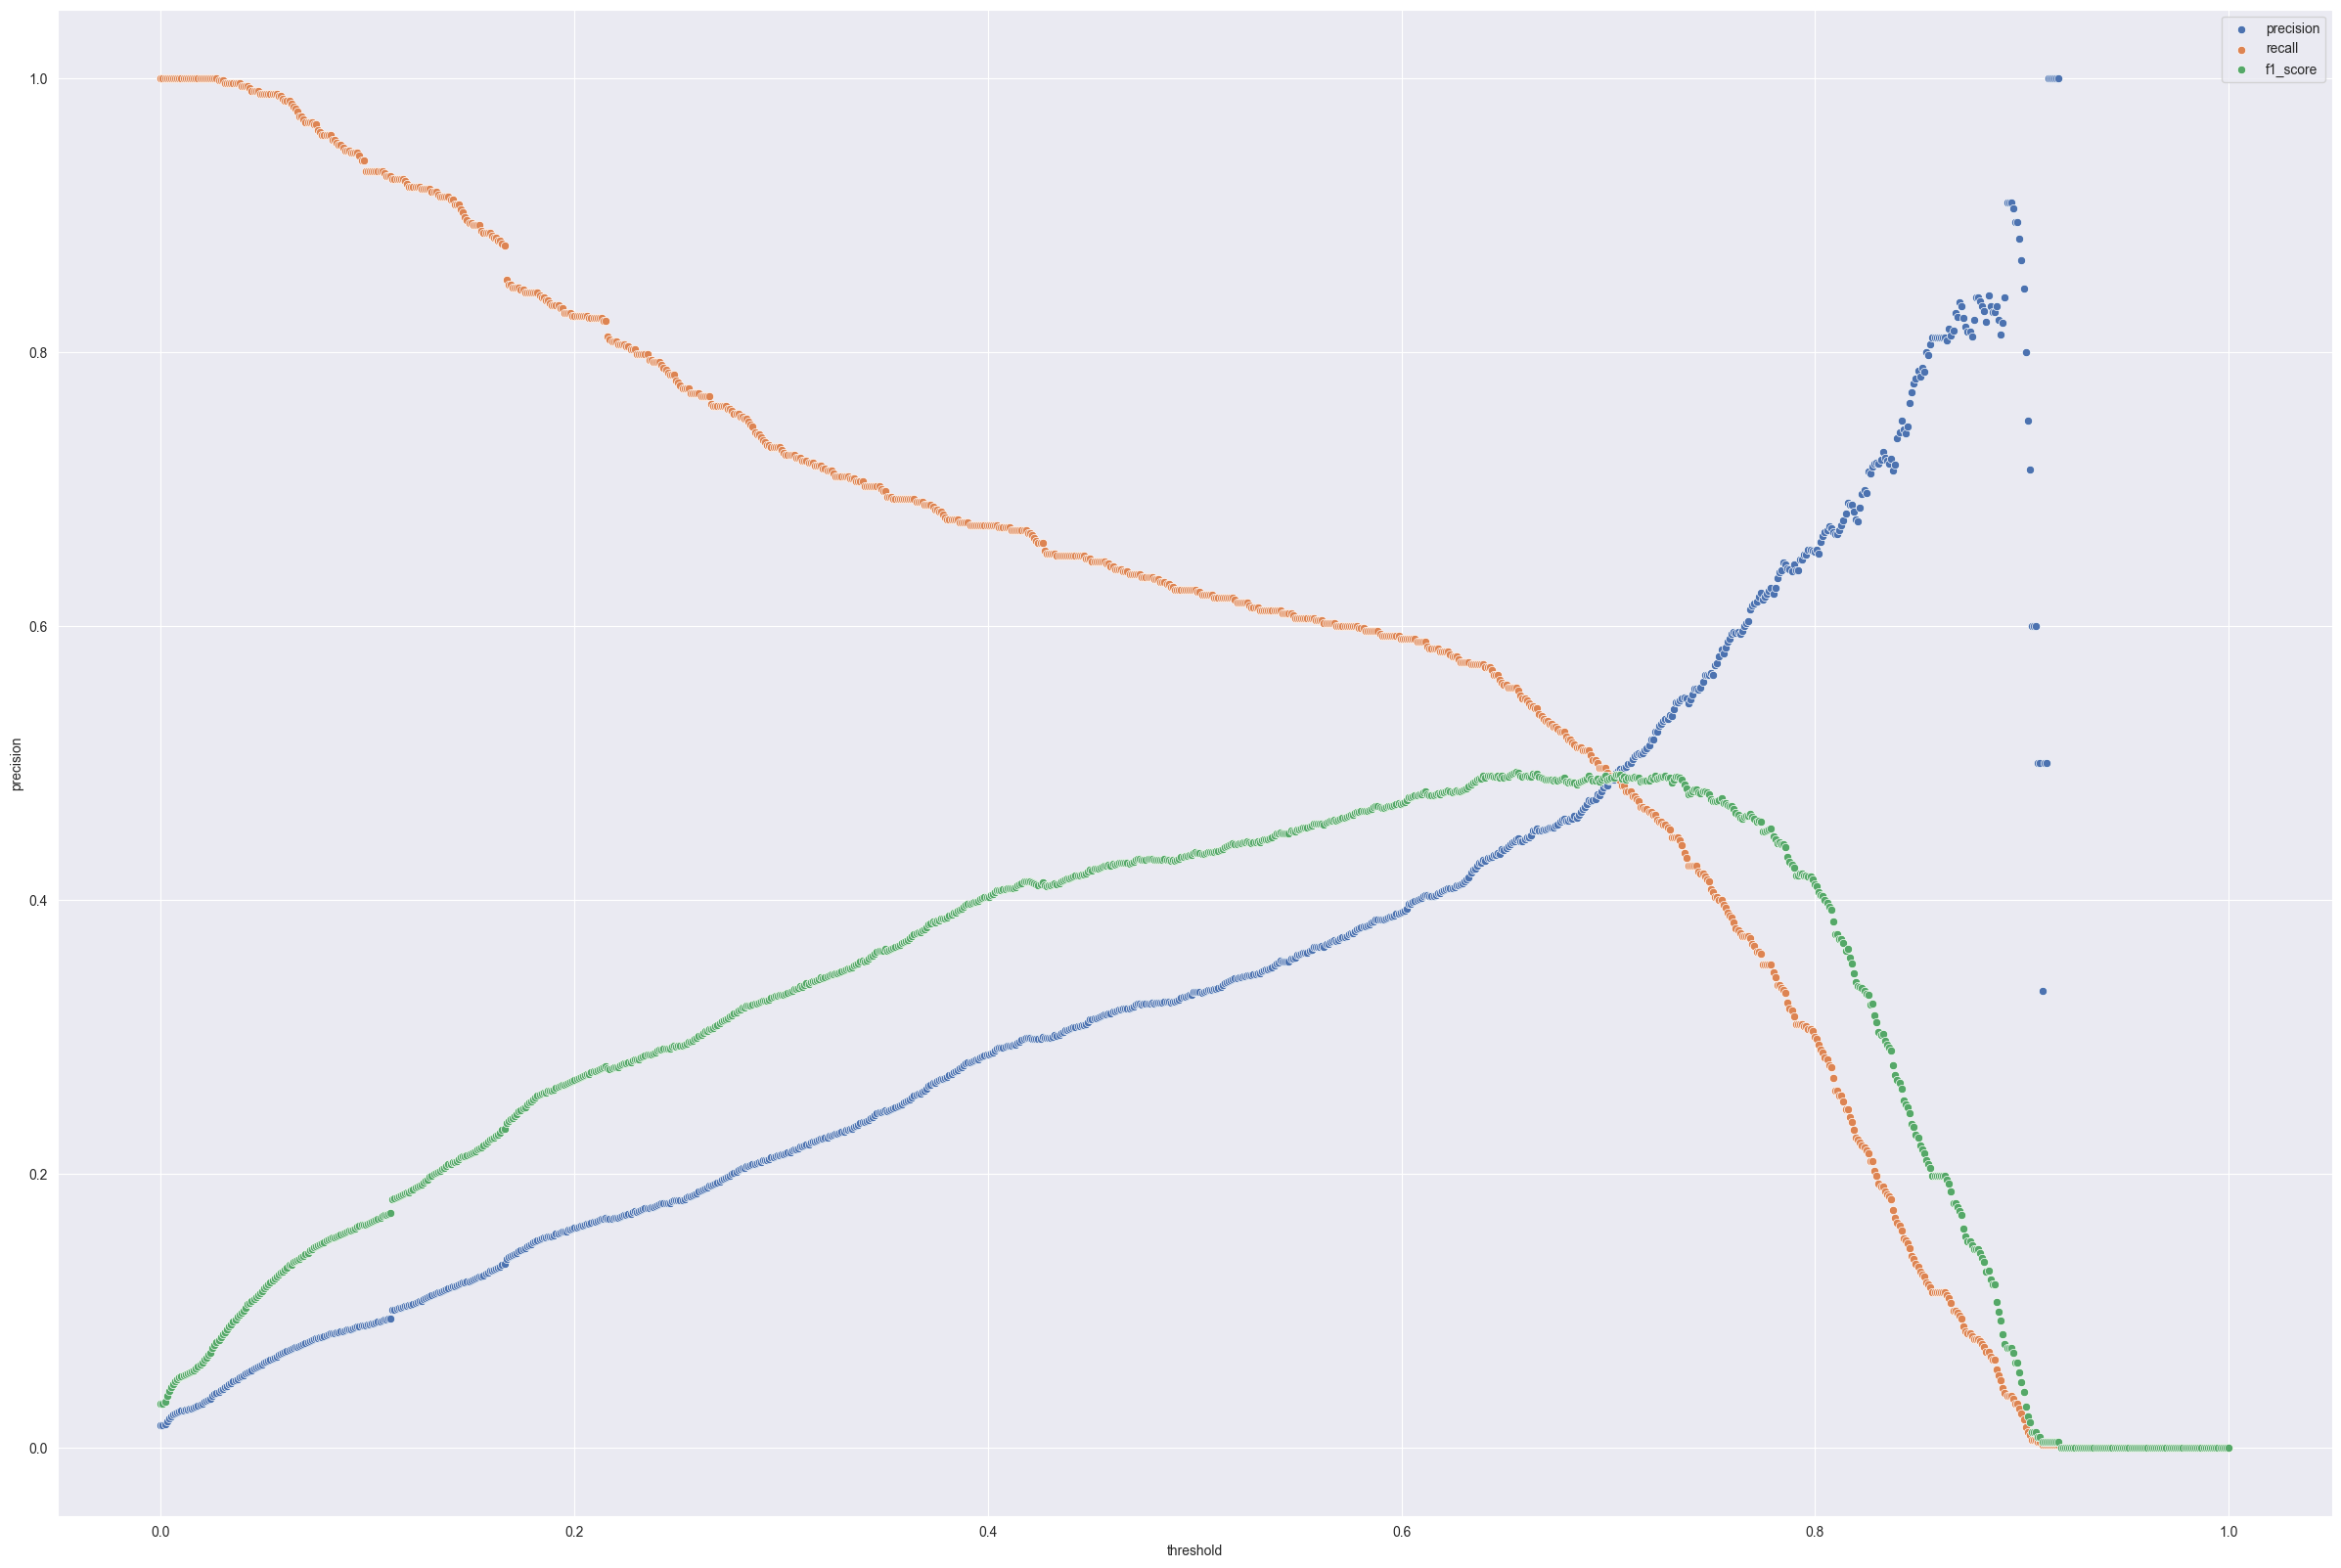

In [46]:
data_scores = pd.DataFrame(
    data=scores_threshold, columns=["threshold", "precision", "recall", "f1_score"]
)
sns.scatterplot(data_scores, x="threshold", y="precision", label="precision")
sns.scatterplot(data_scores, x="threshold", y="recall", label="recall")
sns.scatterplot(data_scores, x="threshold", y="f1_score", label="f1_score")

In [47]:
data_scores[data_scores.f1_score == data_scores.f1_score.max()]

,threshold,precision,recall,f1_score
655,0.655656,0.444109,0.554717,0.493289


In [48]:
y_pred_test_score = sel_clf.predict_proba(X_test)[:, 1]
pr_auc_test = average_precision_score(y_test, y_pred_test_score)

In [49]:
print(classification_report(y_test, y_pred_test_score > 0.655656))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8011
           1       0.44      0.50      0.47       133

    accuracy                           0.98      8144
   macro avg       0.72      0.75      0.73      8144
weighted avg       0.98      0.98      0.98      8144



In [50]:
pr_auc_test

0.42159736190809927

In [51]:
# Визуализация с помощью SHAP
explainer = shap.TreeExplainer(sel_clf)

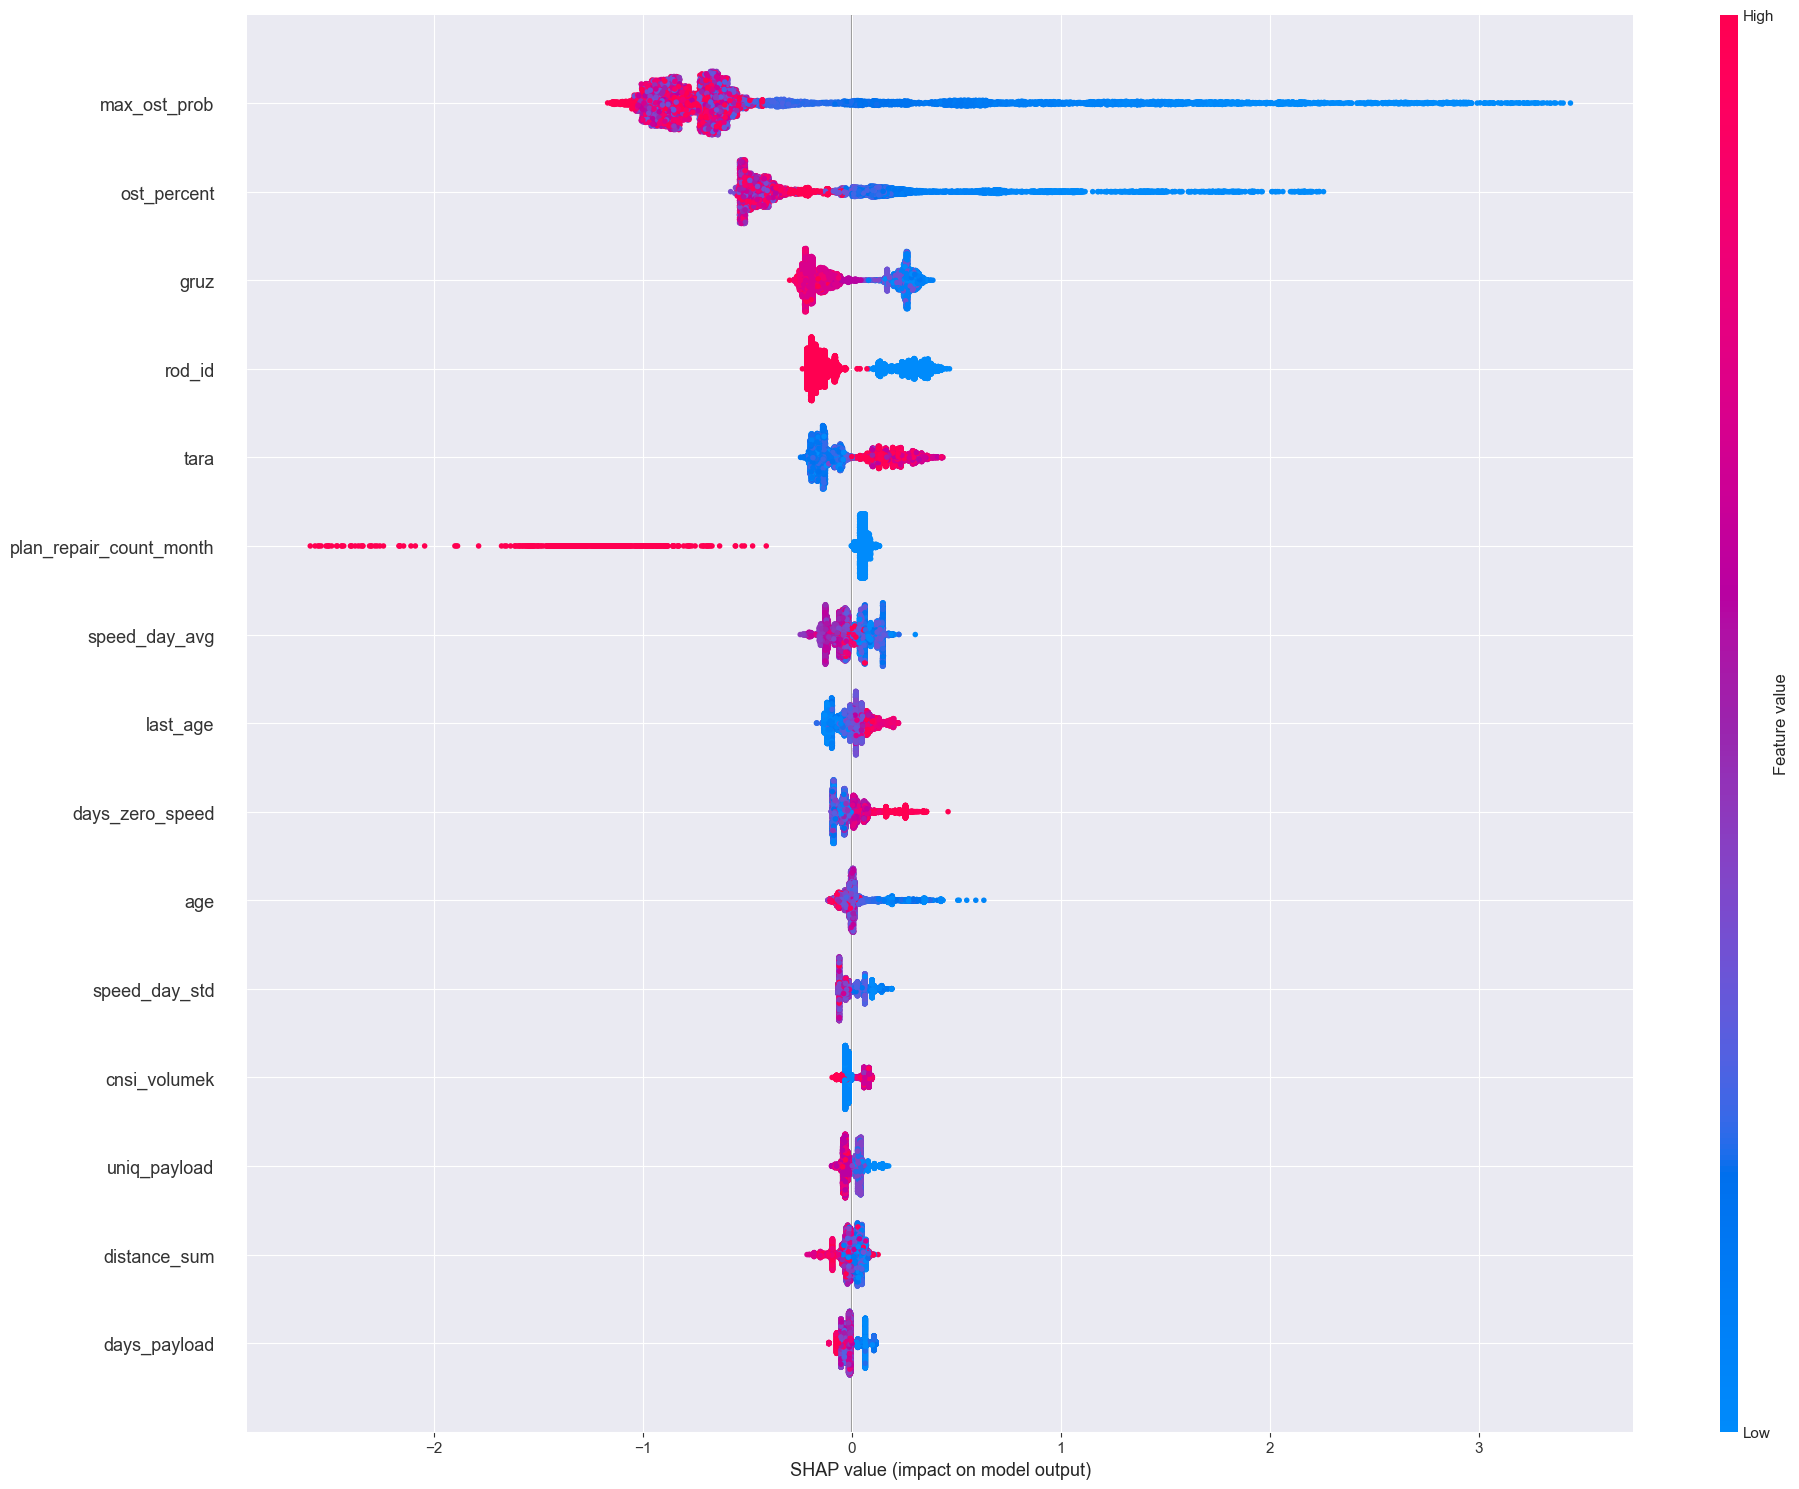

In [52]:
val_dataset = catboost.Pool(data=X_test, label=y_test)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=15, plot_size=(20, 15))

In [53]:
# Предсказание для сабмита
MONTH_THRESHOLD = 0.701702
DAY_THRESHOLD = 0.655656

In [54]:
# Подгрузка моделей
month_clf, day_clf = (
    catboost.CatBoostClassifier().load_model("../models/" + "month_predict_clf_v1"),
    catboost.CatBoostClassifier().load_model("../models/" + "10_day_predict_clf_v1"),
)

In [55]:
# Данные для предсказания
data = optimize_df_memory(
    pd.read_feather(conf.path_processed_folder + "data_predict.feather")
)

Memory usage of dataframe is 8.68 MB
Memory usage after optimization is: 4.53 MB
Decreased by 47.8%


In [56]:
# Для каких вагонов надо предсказать
subm_data = pd.read_csv("../data/raw/submission/y_test.csv")

In [57]:
merged_sub = pd.merge(
    subm_data,
    data,
    how="left",
    left_on=["wagnum", "month"],
    right_on=["wagnum", "month_x"],
)

In [58]:
# Удаление ненужных признако (чисто технических)
drop_features = [
    "wagnum",
    "month",
    "month_x",
    "month_y",
    "month_to_predict",
]

X_predict = merged_sub.drop(columns=drop_features)

In [59]:
merged_sub["target_month"] = (
    month_clf.predict_proba(X_predict)[:, 1] > MONTH_THRESHOLD
).astype(int)
merged_sub["target_day"] = (
    day_clf.predict_proba(X_predict)[:, 1] > DAY_THRESHOLD
).astype(int)

In [60]:
# Генерация посылки
merged_sub[["wagnum", "month", "target_month", "target_day"]].to_csv(
    "../data/final/submission_v4_1000.csv", index=False
)